### New way to find circles - hough circles and voting  working ok 03/31/2022
---
* if you don't have it, get it with `pip install opencv-python`
* i added training photos to the training_images folder

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import pandas as pd
from skimage.draw import disk

### open and display an image with matplotlib

In [86]:
pwd

'C:\\Cory\\CJH Shared\\Python\\FRC\\FRC_training\\notebooks\\vision'

In [87]:
files = glob.glob('**images_15/*.png*', recursive=True)
files

['images_15\\test_001.png',
 'images_15\\test_002.png',
 'images_15\\test_003.png',
 'images_15\\test_004.png',
 'images_15\\test_005.png',
 'images_15\\test_006.png',
 'images_15\\test_007.png',
 'images_15\\test_008.png',
 'images_15\\test_009.png',
 'images_15\\test_010.png',
 'images_15\\test_011.png',
 'images_15\\test_012.png',
 'images_15\\test_013.png',
 'images_15\\test_014.png',
 'images_15\\test_015.png',
 'images_15\\test_016.png',
 'images_15\\test_017.png',
 'images_15\\test_018.png']

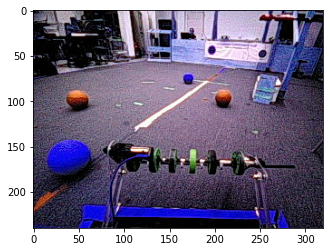

In [88]:
img = cv2.imread(files[0])   # Read the image as BGR
plt.imshow(img)   # Ploting the image using matplotlib

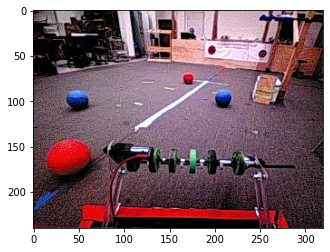

In [89]:
# convert to RGB color convention 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

### RGB components

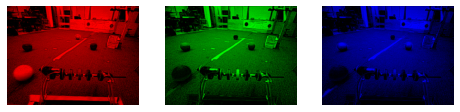

In [90]:
# look at the individual components in RGB space
fix, axs = plt.subplots(ncols=3, nrows=1, figsize=(8,3))
for ix, ax in enumerate(axs):
    temp = np.zeros(img_rgb.shape, dtype='uint8')
    temp[:,:,ix] = img_rgb[:,:,ix]
    ax.imshow(temp)
    ax.set_axis_off()
plt.show()

### HSV components  - note H goes to 180

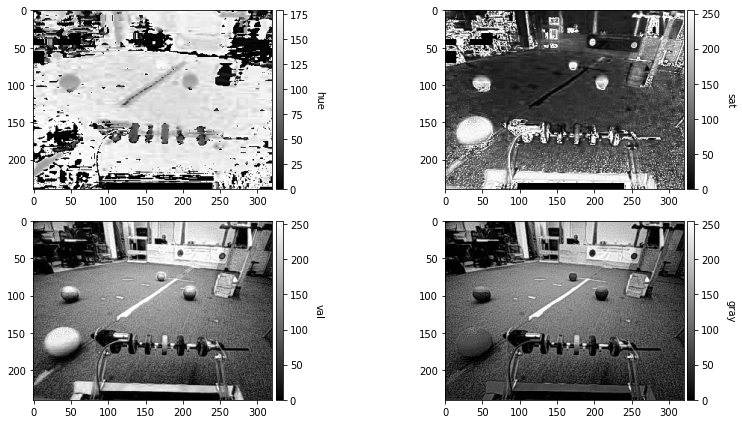

In [91]:
# look at them in HSV space
# look at the individual components in RGB space
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
divider = [None, None, None, None]
cax = [None, None, None, None]
cbar_legend = ['hue', 'sat', 'val', 'gray']
cmap = 'gray'
for ix, ax in (enumerate(axs.flatten()[0:3])):
    temp = np.zeros(img_hsv.shape[0:2], dtype='uint8')
    temp[:,:] = img_hsv[:,:,ix]
    im = ax.imshow(temp, cmap=cmap)
    divider[ix] = make_axes_locatable(ax)
    cax[ix] = divider[ix].append_axes("right", size="3%", pad=0.05)
    cb = plt.colorbar(im, cax=cax[ix])
    cb.ax.set_ylabel(cbar_legend[ix], rotation=270, labelpad=15)
    ax.imshow(temp, cmap=cmap)

ix=3
ax = axs[1,1]
temp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
im = ax.imshow(temp, cmap=cmap)
divider[ix] = make_axes_locatable(ax)
cax[ix] = divider[ix].append_axes("right", size="3%", pad=0.05)
cb = plt.colorbar(im, cax=cax[ix])
cb.ax.set_ylabel(cbar_legend[ix], rotation=270, labelpad=15)
ax.imshow(temp, cmap=cmap)
    
fig.tight_layout()

### start experimenting with circles

In [92]:
# tell if two circles overlap within a threshold number of pixels
def circle_overlap(c1, c2, thresh=20):
    dist =  ((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2) **0.5
    return dist < thresh

In [227]:
# make a list of all centers where the votes are 2 or more, given the dictionary of circles passed to us
# Todo: figure out the best sorting method.  If we go by y then it sorts by closest
def find_matches(image_circles):
    matches = []
    for key_1 in image_circles:
        for key_2 in image_circles:
            if key_1 < key_2:
                for ix, c1 in enumerate(image_circles[key_1]):
                    for iy, c2 in enumerate(image_circles[key_2]):
                        #print(f'{key_1},{key_2}: {c1} {c2} {circle_overlap(c1,c2)}')
                        if circle_overlap(c1, c2):
                            better = c1 if c1[2] > c2[2] else c2
                            matches.append([key_1, ix, key_2, iy, better])
    matches = sorted(matches, key=lambda x: (x[4][0], x[4][2]))
    # matches
    best_matches = []
    count = 1
    for ix, match in enumerate(matches[:-1]):
        if circle_overlap(matches[ix][4], matches[ix+1][4]):
            count += 1
        else:
            best_matches.append([matches[ix], count])
            count = 1
    # how do we take care of the final case? 
    if circle_overlap(matches[ix][4], matches[ix+1][4]):
        best_matches.append([matches[ix], count])
    else:
        best_matches.append([matches[ix+1], 1])
    best_matches = sorted(best_matches, key=lambda x: -x[0][4][1]) # reverse on y - closest is on top of list
    return best_matches

In [228]:
def detect_circles(img, draw_circles=True):

    global gray, h, s, v, r, g, b
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    [h, s, v] = [img_hsv[:,:,ix] for ix in range(3)]
    r, g, b = cv2.split(img)
    top, bot = 60, 160

    # clahe = cv2.createCLAHE(clipLimit=5., tileGridSize=(8, 8))
    # lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space

    # l, a, b = cv2.split(lab)  # split on 3 different channels
    # l2 = clahe.apply(gray)  # apply CLAHE to the L-channel
    # lab = cv2.merge((l2, a, b))  # merge channels
    # clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
                
    arrays = [r, s, v, gray]
    image_circles = {}
    for a in arrays:
        a[:top,:] = 0
        a[bot:,:] = 0
    
    for ix, a in enumerate(arrays):
        circles = cv2.HoughCircles(a, cv2.HOUGH_GRADIENT_ALT, 1, minDist=20, param1=1, param2=0.2, minRadius=3, maxRadius=20)
        if ix >= 0:  # not really necessary, but it was when testing for best channels
            if circles is not None:
                image_circles.update({ix:circles[0, :]})
  
    if draw_circles:
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
        divider = [None, None, None, None]; cax = [None, None, None, None]
        cbar_legend = ['red', 'sat', 'val', 'gray']; cmap = 'gray'
        for ix, ax in (enumerate(axs.flatten())):
            im = ax.imshow(arrays[ix], cmap=cmap)
            divider[ix] = make_axes_locatable(ax)
            cax[ix] = divider[ix].append_axes("right", size="3%", pad=0.05)
            cb = plt.colorbar(im, cax=cax[ix])
            cb.ax.set_ylabel(cbar_legend[ix], rotation=270, labelpad=15)

            cimg = cv2.cvtColor(arrays[ix], cv2.COLOR_GRAY2BGR)

            if circles is not None:
                for i in circles[0, :]:
                    #Draw outer circle (blue)
                    cv2.circle(cimg, (int(i[0]), int(i[1])), int(i[2]), (0, 255, 0), 2)
                    #Draw Center (red)
                    #cv2.circle(cimg, (int(i[0]), int(i[1])), 2, (255, 255, 0), 3)
            ax.imshow(cimg, cmap=cmap)
        fig.tight_layout()    
        plt.show()
    return image_circles

In [259]:
# show the circles
def draw_circles(img, show_hough=True, plot=True, debug=True, verbose=True):
    circles_dict = {'red':{'count':0, 'circles':[]}, 'blue':{'count':0, 'circles':[]}, 'ball':{'count':0, 'circles':[]}, 'other':{'count':0, 'circles':[]}} 
    image_circles = detect_circles(img, draw_circles=show_hough )
    best_matches = find_matches(image_circles)
    cimg = img.copy()
    for ix, match in enumerate(best_matches):
        i = match[0][4]
        mask = np.zeros((cimg.shape[0], cimg.shape[1]))
        mask[:] = np.NaN
        col = int(match[0][4][0])
        row = int(match[0][4][1])
        radius = match[0][4][2]
        rr, cc = disk((row, col), radius//2)
        mask[rr, cc] = 1
        rm = np.nanmedian(mask * r); gm = np.nanmedian(mask * g); bm=np.nanmedian(mask * b)
        sm = np.nanmedian(mask * s); hm = np.nanmedian(mask * h)
        match_count = str(match[-1])
        if sm > 130:  # use sat as the main criteria for it being a ball
            if rm > 100 and (hm > 160 or hm < 10):  # probably could skip the red channel logic
                label = 'red ' + match_count
                circles_dict['red']['count'] += 1
                circles_dict['red']['circles'].append([col, row, radius])
            elif rm < 60 and hm < 125 and hm > 100:   # probably could skip the red channel logic
                label = 'blue ' + match_count
                circles_dict['blue']['count'] += 1
                circles_dict['blue']['circles'].append([col, row, radius])
            else:
                label = 'c?' + match_count
                circles_dict['ball']['count'] += 1
                circles_dict['ball']['circles'].append([col, row, radius])
        else:
            label = 'nb' + match_count
            circles_dict['other']['count'] += 1
            circles_dict['ball']['circles'].append([col, row, radius])
        
        #Draw Center (yellow)
        cv2.circle(cimg, (int(i[0]), int(i[1])), 1, (255, 255, 0), 2)
        if 'nb' not in label:
            #Draw outer circle (green)
            cv2.circle(cimg, (int(i[0]), int(i[1])), int(i[2]), (0, 255, 0), 2)
            
            if debug:
                textcolor = (255,255,255)
                cv2.putText(cimg, label, (col-15, row-15), 1, 1.1, textcolor, 1, cv2.LINE_AA)  # text: img, text, location, font, scale, color, thickness, line type   
            if verbose:
                print(f'{ix}: ({col},{row}) {label} R:{np.nanmedian(mask * r)}, G:{np.nanmedian(mask * g)}, B:{np.nanmedian(mask * b)}, S:{np.nanmedian(mask * s)}, H:{np.nanmedian(mask * h)}')
    
    
    x_resolution, y_resolution = cimg.shape[1], cimg.shape[0]
    info_label = f"R{circles_dict['red']['count']} B{circles_dict['blue']['count']} S{circles_dict['ball']['count']} ?{circles_dict['other']['count']}"
    cv2.rectangle(cimg, (0, 0), (x_resolution, int(0.1 * y_resolution)), (0, 0, 0), -1)
    cv2.putText(cimg, info_label, (10, 15), 1, 1.1, (255,255,255), 1, cv2.LINE_AA)
    
    if plot:
        plt.imshow(cimg)
    
    return cimg

In [260]:
best_matches

[[[0, 3, 2, 3, array([ 51.      , 105.      ,  11.996209], dtype=float32)], 3],
 [[1, 2, 3, 3, array([210.      ,  98.      ,  12.266611], dtype=float32)], 3],
 [[2, 0, 3, 0, array([262.     ,  82.     ,  13.67163], dtype=float32)], 6],
 [[0, 1, 3, 2, array([295.      ,  71.      ,  12.132943], dtype=float32)], 4]]

0: R:4.0, G:7.0, B:10.0, S:202.0, H:114.0
1: R:14.0, G:26.0, B:115.0, S:211.0, H:116.0
2: R:185.0, G:125.0, B:105.0, S:111.0, H:7.0
3: R:12.0, G:8.0, B:5.0, S:128.0, H:11.0


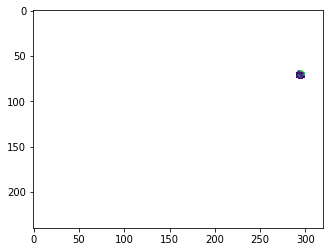

In [261]:
for ix, match in enumerate(best_matches):
    mask = np.zeros((240, 320))
    mask[:] = np.NaN
    col = match[0][4][0]
    row = match[0][4][1]
    radius = match[0][4][2]
    rr, cc = disk((row, col), radius//2)
    mask[rr, cc] = 1
    print(f'{ix}: R:{np.nanmedian(mask * r)}, G:{np.nanmedian(mask * g)}, B:{np.nanmedian(mask * b)}, S:{np.nanmedian(mask * s)}, H:{np.nanmedian(mask * h)}')
plt.imshow(mask*r)

#### test all at once

In [262]:
# remove white lines from image  - may have to incorporate this into pipeline
imgs = []
for file in files:
    img_rgb = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    mask = np.logical_and(img_rgb[:,:,0] > 200, img_rgb[:,:,1] > 200,  img_rgb[:,:,2] > 200)
    #img_rgb[mask] = [127,127,127]
    
    imgs.append(img_rgb)

0: (45,153) red 1 R:234.0, G:14.0, B:27.0, S:240.0, H:178.0
1: (52,100) blue 3 R:15.0, G:25.0, B:98.0, S:210.0, H:117.0
2: (210,97) blue 6 R:16.0, G:31.0, B:132.0, S:209.0, H:115.0
4: (171,75) red 6 R:175.0, G:13.0, B:39.0, S:237.0, H:175.0


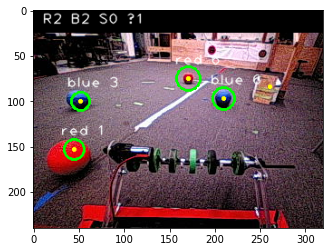

In [263]:
_ = draw_circles(imgs[0], plot=True, debug=True, show_hough=False)

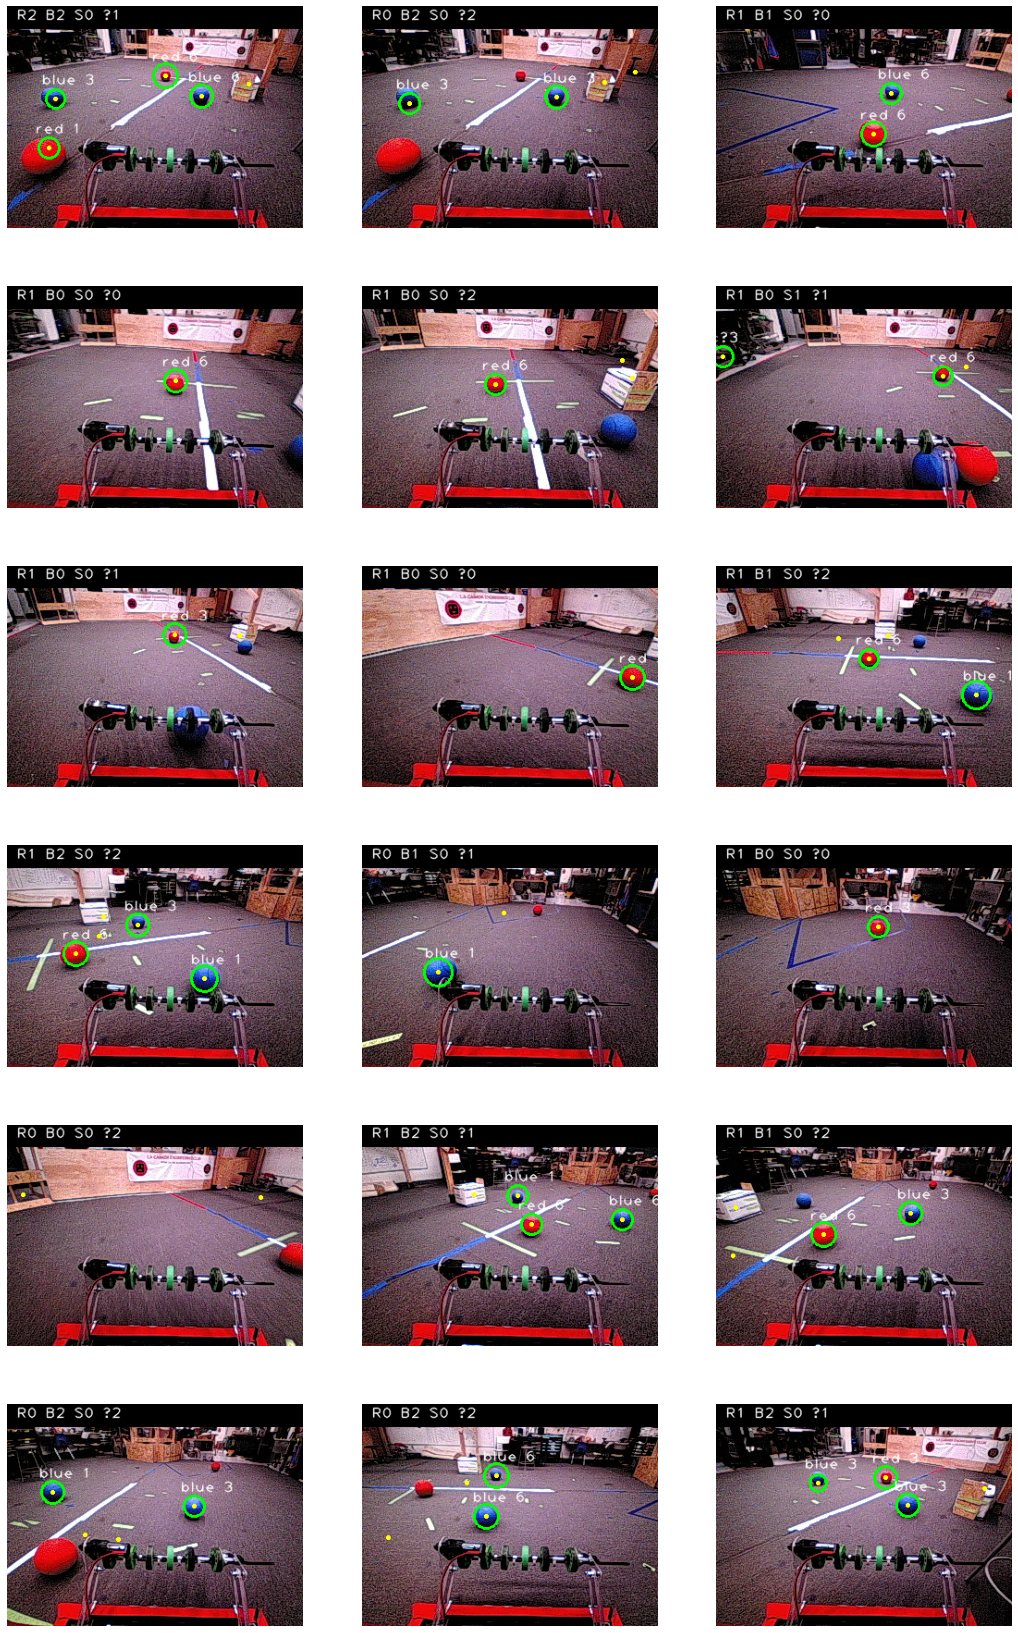

Wall time: 1.84 s


In [211]:
%%time
fig, axs = plt.subplots(ncols=3, nrows=6, figsize=(18,30))
for ix, row in enumerate(axs):
    for iy, ax in enumerate(row):
        detailed_image = draw_circles(imgs[3*ix + iy], plot=True, verbose=False, debug=True, show_hough=False)
        ax.imshow(detailed_image)
        ax.set_axis_off()
plt.show()

0: (19,96) c?3 R:101.0, G:63.0, B:33.0, S:157.0, H:15.0
7: (246,99) blue 6 R:39.0, G:82.0, B:115.0, S:169.0, H:103.0


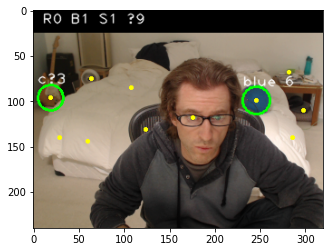

In [212]:
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
s, im = cam.read()
if s > 0:
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (320,240), interpolation=cv2.INTER_AREA)
    # cv2.imshow(f'Test Picture', im)
    #cv2.waitKey(delay=100)
cam.release() 
#cv2.waitKey(0)
#cv2.destroyAllWindows()
plt.imshow(draw_circles(im, plot=True, verbose=True, debug=True, show_hough=False))

#### development

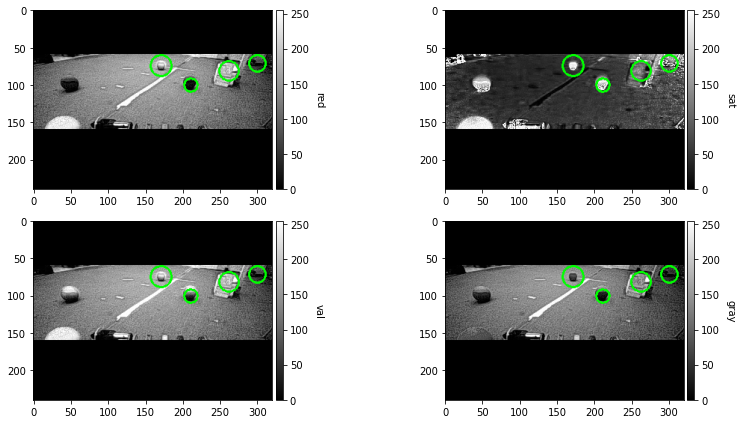

In [205]:
image_circles = detect_circles(imgs[1])

In [125]:
matches = []
for key_1 in image_circles:
    for key_2 in image_circles:
        if key_1 < key_2:
            for ix, c1 in enumerate(image_circles[key_1]):
                for iy, c2 in enumerate(image_circles[key_2]):
                    #print(f'{key_1},{key_2}: {c1} {c2} {circle_overlap(c1,c2)}')
                    if circle_overlap(c1, c2):
                        better = c1 if c1[2] > c2[2] else c2
                        matches.append([key_1, ix, key_2, iy, better])
matches = sorted(matches, key=lambda x: (x[4][0], x[4][2]))
_ = [print(match) for match in matches]
best_matches = []
count = 1
for ix, match in enumerate(matches[:-1]):
    if circle_overlap(matches[ix][4], matches[ix+1][4]):
        count += 1
    else:
        best_matches.append([matches[ix], count])
        count = 1

# how do we take care of the final case? 
if circle_overlap(matches[ix][4], matches[ix+1][4]):
    best_matches.append([matches[ix], count+1])
else:
    best_matches.append([matches[ix+1], 1])
    
best_matches = sorted(best_matches, key=lambda x: x[0][4][0])
best_matches

[1, 1, 2, 3, array([47.      , 99.      , 11.701878], dtype=float32)]
[0, 3, 1, 1, array([ 51.      , 105.      ,  11.996209], dtype=float32)]
[0, 3, 2, 3, array([ 51.      , 105.      ,  11.996209], dtype=float32)]
[0, 2, 3, 3, array([210.      ,  96.      ,  12.101399], dtype=float32)]
[0, 2, 1, 2, array([210.      ,  98.      ,  12.266611], dtype=float32)]
[1, 2, 3, 3, array([210.      ,  98.      ,  12.266611], dtype=float32)]
[0, 0, 1, 0, array([255.      ,  87.      ,  14.909829], dtype=float32)]
[0, 0, 2, 0, array([255.      ,  87.      ,  14.909829], dtype=float32)]
[0, 0, 3, 0, array([255.      ,  87.      ,  14.909829], dtype=float32)]
[1, 0, 2, 0, array([257.      ,  78.      ,  12.619194], dtype=float32)]
[1, 0, 3, 0, array([262.     ,  82.     ,  13.67163], dtype=float32)]
[2, 0, 3, 0, array([262.     ,  82.     ,  13.67163], dtype=float32)]
[0, 1, 2, 1, array([295.      ,  71.      ,  12.132943], dtype=float32)]
[0, 1, 3, 2, array([295.      ,  71.      ,  12.132943], dty

[[[0, 3, 2, 3, array([ 51.      , 105.      ,  11.996209], dtype=float32)], 3],
 [[1, 2, 3, 3, array([210.      ,  98.      ,  12.266611], dtype=float32)], 3],
 [[2, 0, 3, 0, array([262.     ,  82.     ,  13.67163], dtype=float32)], 6],
 [[0, 1, 3, 2, array([295.      ,  71.      ,  12.132943], dtype=float32)], 4]]

In [126]:
circles = cv2.HoughCircles(v, cv2.HOUGH_GRADIENT, 1, 20,
                     param1=50, param2=40, minRadius=10, maxRadius=50)
circles

array([[[194.5, 109.5,  49.4],
        [273.5, 106.5,  45. ],
        [ 72.5, 101.5,  42.7],
        [133.5, 106.5,  35. ],
        [ 96.5, 112.5,  33.8],
        [208.5, 125.5,  33.8],
        [227.5, 111.5,  33.8],
        [254.5, 118.5,  31.6],
        [ 54.5, 111.5,  29.4],
        [ 47.5,  90.5,  23.9],
        [178.5, 129.5,  23.9],
        [256.5,  92.5,  21.6],
        [115.5,  92.5,  21.7],
        [285.5, 132.5,  22.4],
        [209.5,  92.5,  19.4],
        [ 28.5, 122.5,  17.2],
        [116.5, 122.5,  17.2],
        [145.5, 130.5,  16. ],
        [ 41.5, 138.5,  15. ],
        [240.5, 138.5,  13.8]]], dtype=float32)

#### making decisions
* the sat for a ball is always good
* hue is pretty reliable
* red vs blue also good as the tie breaker

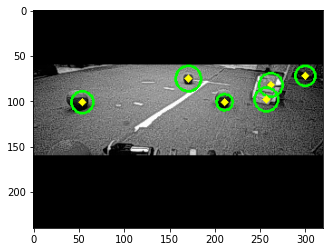

In [127]:
cimg = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, 1, minDist=10,
                           param1=2, param2=0.2, minRadius=3, maxRadius=30)
for i in circles[0, :]:
    #Draw outer circle (blue)
    cv2.circle(cimg, (int(i[0]), int(i[1])), int(i[2]), (0, 255, 0), 2)

    #Draw Center (red)
    cv2.circle(cimg, (int(i[0]), int(i[1])), 2, (255, 255, 0), 3)
plt.imshow(cimg)

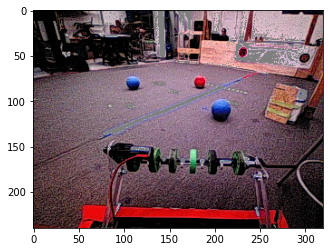

In [128]:
mask = np.logical_and(img_rgb[:,:,0] > 200, img_rgb[:,:,1] > 200,  img_rgb[:,:,2] > 200)
img_rgb[mask] = [127,127,127]
plt.imshow(img_rgb)

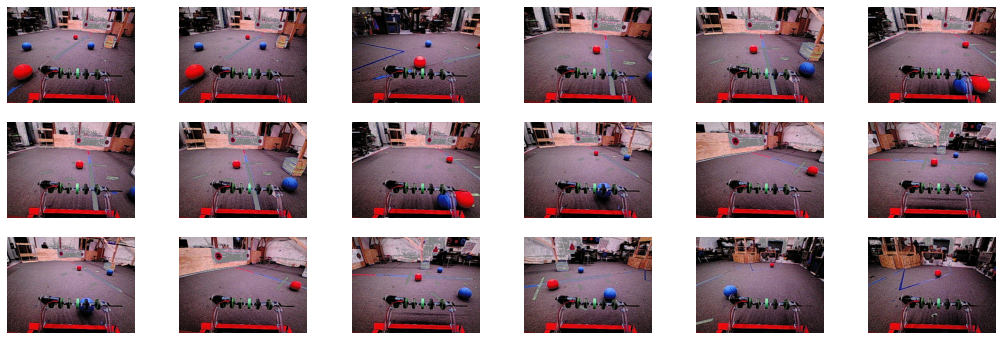

In [129]:
imgs = []
for file in files:
    img_rgb = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    mask = np.logical_and(img_rgb[:,:,0] > 200, img_rgb[:,:,1] > 200,  img_rgb[:,:,2] > 200)
    img_rgb[mask] = [127,127,127]
    
    imgs.append(img_rgb)
    
fig, axs = plt.subplots(ncols=6, nrows=3, figsize=(18,6))
for ix, row in enumerate(axs):
    for iy, ax in enumerate(row):
        ax.imshow(imgs[3*ix + iy])
        ax.set_axis_off()
        
plt.show()

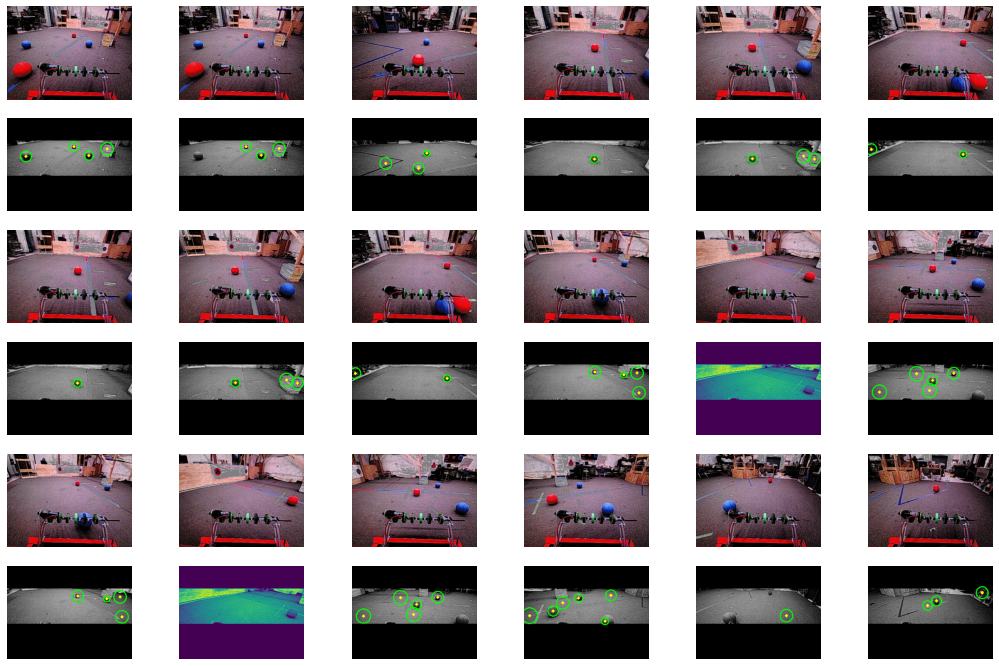

Wall time: 1.27 s


In [131]:
%%time
cimgs = []
for img in imgs: 
    top, bot = 60, 150
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray[:top,:] = 0; gray[bot:,:] = 0
    cimg = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, 1, minDist=20,
                           param1=10, param2=0.15, minRadius=4, maxRadius=25)
    # circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, minDist=20,
    #                        param1=5, param2=20, minRadius=5, maxRadius=30)
    if circles is not None:
        for i in circles[0, :]:
            #Draw outer circle (blue)
            cv2.circle(cimg, (int(i[0]), int(i[1])), int(i[2]), (0, 255, 0), 2)
            #Draw Center (red)
            cv2.circle(cimg, (int(i[0]), int(i[1])), 2, (255, 255, 0), 3)
        cimgs.append(cimg)
    else:
        cimgs.append(gray)
    
fig, axs = plt.subplots(ncols=6, nrows=6, figsize=(18,12))
for ix, row in enumerate(axs):
    for iy, ax in enumerate(row):
        if ix % 2 == 0:
            ax.imshow(imgs[3*(ix//2) + iy])
        else:
            ax.imshow(cimgs[3*(ix-1)//2 + iy])
        ax.set_axis_off()
plt.show()

#### see how it worked - not much guesswork anymore...

In [36]:
def hsv_threshold(input, hue, sat, val):
    """Segment an image based on hue, saturation, and value ranges.
    Args:
        input: A BGR numpy.ndarray.
        hue: A list of two numbers the are the min and max hue.
        sat: A list of two numbers the are the min and max saturation.
        lum: A list of two numbers the are the min and max value.
    Returns:
        A black and white numpy.ndarray.
    """
    out = cv2.cvtColor(input, cv2.COLOR_RGB2HSV)
    return cv2.inRange(out, (hue[0], sat[0], val[0]), (hue[1], sat[1], val[1]))

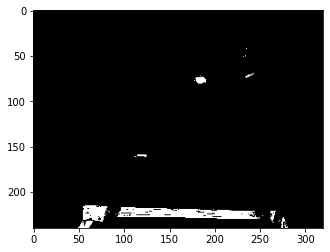

In [37]:
h = [165,180]
h2 =  [0, 0]
s = [120,255]
v = [180,255]
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h, s, v) + hsv_threshold(img_rgb.copy(), h2, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')

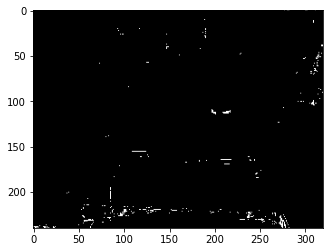

In [38]:
h = [120,150]
s = [150,255]
v = [50,200]
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h, s, v) + hsv_threshold(img_rgb.copy(), h2, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')

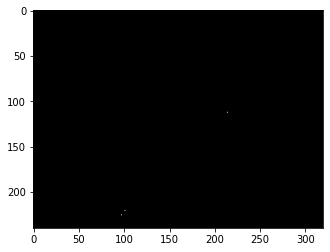

In [39]:
eroded = cv2.erode(hsv_thresh_image, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1) 
plt.imshow(eroded, cmap='gray')

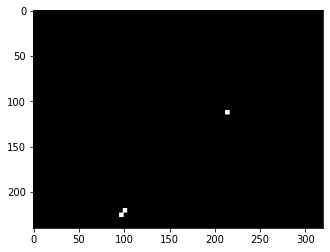

In [40]:
dilated = cv2.dilate(eroded, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=2) 
plt.imshow(dilated, cmap='gray')

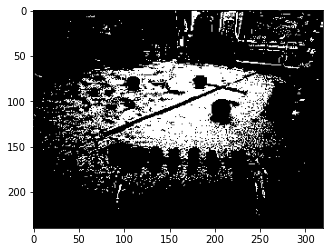

In [41]:
hue_tolerance = 5
h = [training_data['MIN_HUE'] - hue_tolerance, training_data['MAX_HUE'] + hue_tolerance]
s = [training_data['MIN_SAT'], training_data['MAX_SAT']]
v = [training_data['MIN_VAL'], training_data['MAX_VAL']]
hsv_thresh_image = hsv_threshold(img_rgb.copy(), h, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')